In [1]:
# baixar e descompactar os dados do exemplo
# Será criado a pasta hymenoptera_data no ambiente do colab

!wget -O hymenoptera_data.zip https://www.dropbox.com/s/154i61alh62e7jl/hymenoptera_data.zip?dl=0;

!unzip hymenoptera_data.zip;

--2021-08-22 22:14:03--  https://www.dropbox.com/s/154i61alh62e7jl/hymenoptera_data.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.85.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.85.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/154i61alh62e7jl/hymenoptera_data.zip [following]
--2021-08-22 22:14:03--  https://www.dropbox.com/s/raw/154i61alh62e7jl/hymenoptera_data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc177831711eca970d1939c043a0.dl.dropboxusercontent.com/cd/0/inline/BUtG8DpiOOSlbnab7LdgikR6mwMF9OCrSGJbx2x9foA1yHzilhpbbNdvd0F7tL4jvnS3FchfgUB7bVdQr9YJtJps2_Uv8faagrlXuCVFJjCWdjjy8x9kYLHvpFXekAa5KuYf5sEKAj5o1w-XwhCVm1Dt/file# [following]
--2021-08-22 22:14:04--  https://uc177831711eca970d1939c043a0.dl.dropboxusercontent.com/cd/0/inline/BUtG8DpiOOSlbnab7LdgikR6mwMF9OCrSGJbx2x9foA1yHzilhpbbNdvd0

In [2]:
#imports necessários

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
# Criando os datasets e dataloaders

# Aqui usamos a função ImageFolder para criar um dataset deireto das pastas organizadas train e val.
# O pytorch entende automaticamente os nomes das pastas ants e bees como as classes.

data_dir = 'hymenoptera_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f'Dataset sizes: {dataset_sizes}')
print(f'class names: {class_names}')
print(f'cuda: {device}')

Dataset sizes: {'train': 244, 'val': 153}
class names: ['ants', 'bees']
cuda: cuda:0


In [5]:
# Funções auxiliares para a prática

# Função auxiliar para impimir um batch de imagens

def imshow(inp, title=None):
    """Imshow for Tensor."""

    #plt.figure(figsize=(10, 8))

    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated



# Function to test output dimension
def out_conv2d(dim_input, kernel_size, padding=0, dilation=1, stride=1):
    dim_output = ((dim_input + 2 * padding - dilation * (kernel_size-1) - 1)/stride) + 1
    return dim_output

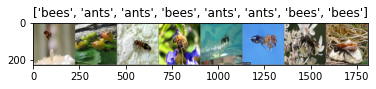

In [6]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
# função de treino

def train_model(model, criterion, optimizer, num_epochs=15):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
# Função a ser chamada após treino para visualizar a classificação de um batch

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [9]:
# testando as saidas da camadas conv2d
# Use esta opção para clacular corretamente as dimensões

# Insira a dimensão de entrada e o tamanho do filtro
out_conv2d(111, 3)

109.0

In [10]:
# Criando uma rede convolucional

class classificador(nn.Module):

  def __init__(self):
    super().__init__()

    # Criação das camadas convolucionais
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3,3)) # saida 222x222 (no pooling cai pela metade -> 111)
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3)) #saida 109x109 (no pooling cai pela metade -> 54)

    # Criação da função relu
    self.activation = nn.ReLU()

    # Criação do pooling
    self.pool = nn.MaxPool2d(kernel_size = (2,2))

    # Criação do flatten para vetorzar a imagem ao final das camadas conv
    self.flatten = nn.Flatten() # 54*54 * 128 channels

    # Camadas lineares da rede neural
    self.linear1 = nn.Linear(in_features=128 * 54*54, out_features=128)
    self.linear2 = nn.Linear(128, 64)
    self.output = nn.Linear(64, 2)

    # Dropout para diminuir overfitting
    self.dropout = nn.Dropout(p = 0.2)

  # Fluxo da passagem da imagem na rede 
  def forward(self, X):
    X = self.pool(self.activation(self.conv1(X)))
    X = self.pool(self.activation(self.conv2(X)))
    
    X = self.flatten(X)

    X = self.dropout(self.activation(self.linear1(X)))
    X = self.dropout(self.activation(self.linear2(X)))
    X = self.output(X)

    return X

In [11]:
# Criando objeto da estrutura da rede

net = classificador()
print(net)

classificador(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (activation): ReLU()
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=373248, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [12]:
# Definindo parâmetros importantes do treinamento

#Função de custo e função de otimização dos parâmetros

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [13]:
# Colocar a rede na gpu
net.to(device)

classificador(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (activation): ReLU()
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=373248, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [14]:
# treinar modelo
trained_model = train_model(net, criterion, optimizer, num_epochs=15)

Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.7013 Acc: 0.5287
val Loss: 0.7291 Acc: 0.4575

Epoch 1/14
----------
train Loss: 0.6924 Acc: 0.5041
val Loss: 0.7088 Acc: 0.5033

Epoch 2/14
----------
train Loss: 0.6457 Acc: 0.6189
val Loss: 0.6656 Acc: 0.6144

Epoch 3/14
----------
train Loss: 0.6262 Acc: 0.6434
val Loss: 0.6529 Acc: 0.6209

Epoch 4/14
----------
train Loss: 0.6139 Acc: 0.6721
val Loss: 0.6834 Acc: 0.5686

Epoch 5/14
----------
train Loss: 0.5931 Acc: 0.6639
val Loss: 0.6524 Acc: 0.6275

Epoch 6/14
----------
train Loss: 0.5715 Acc: 0.6926
val Loss: 0.6140 Acc: 0.6732

Epoch 7/14
----------
train Loss: 0.5509 Acc: 0.7213
val Loss: 0.7652 Acc: 0.5686

Epoch 8/14
----------
train Loss: 0.5300 Acc: 0.7459
val Loss: 0.7525 Acc: 0.6013

Epoch 9/14
----------
train Loss: 0.5054 Acc: 0.7213
val Loss: 0.6627 Acc: 0.6209

Epoch 10/14
----------
train Loss: 0.4366 Acc: 0.7910
val Loss: 0.7499 Acc: 0.5817

Epoch 11/14
----------
train Loss: 0.4475 Acc: 0.7910
val Loss: 0.7721 Acc: 0.6209

Epoch 12/14
----------
t

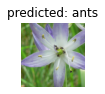

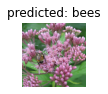

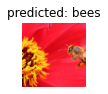

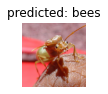

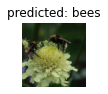

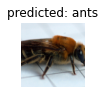

In [ ]:
# Visualizar imagens do conjunto de teste classificadas
visualize_model(trained_model)

### Redes Neurais convolucionais pré treinadas e Transfer Learning

Existem modelos pre treinados disponiveis no modulo models do pytorch.

Estas redes foram treinadas e validadas em competições e são caapzaes de classificar várias coisas, 1000 classes mais precisamente.

Podemos usar estas redes como base para nossos problemas e retreiná-las com nossos dados.



In [ ]:
# Carregando do pytorch a rede chamada vgg16
model_ft = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
print(model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_ft.classifier[6].in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.classifier[6] = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001)

In [ ]:
print(model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# treinar modelo
trained_model = train_model(model_ft, criterion, optimizer_ft, num_epochs=15)

Epoch 0/24
----------
train Loss: 0.3249 Acc: 0.8566
val Loss: 0.3269 Acc: 0.8562

Epoch 1/24
----------
train Loss: 0.2130 Acc: 0.9016
val Loss: 0.1744 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.0766 Acc: 0.9754
val Loss: 0.2815 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.0212 Acc: 0.9959
val Loss: 0.2019 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.0031 Acc: 1.0000
val Loss: 0.1860 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.0015 Acc: 1.0000
val Loss: 0.1958 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.0022 Acc: 1.0000
val Loss: 0.2049 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.0006 Acc: 1.0000
val Loss: 0.2262 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.0016 Acc: 1.0000
val Loss: 0.2487 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.0004 Acc: 1.0000
val Loss: 0.2494 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.0012 Acc: 1.0000
val Loss: 0.2423 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.0012 Acc: 1.0000
val Loss: 0.2729 Acc: 0.9477

Ep